In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates
from cycler import cycler
from collections import OrderedDict
import matplotlib.mlab as ml

%matplotlib notebook

In [2]:
# Save plots?
save = True

In [3]:
# Load HDF file
folder = 'T2_refractive_index_liquids'
data_folder = '../Data/'  # 'Z:/LabOnChip/Data/'
df = pd.HDFStore(data_folder + str(folder) +'/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

In [4]:
df.head()
# df.info()

,datetime,chip,current,fs,humidity,measurementID,medium,optical power,sample_no,sweep_no,sweeps,t_in,t_out,tempC,A,tau,c,delta
0,2016-10-05 14:22:38.950126,T2,0.5,0.0001,36.6,Air,Air,0.229991,1000,1,250,22.75,22.5,23.52,0.462212,12.421697,-0.021594,0.000000
1,2016-10-05 14:22:40.337264,T2,0.5,0.0001,36.6,Air,Air,0.229991,1000,2,250,22.75,22.5,23.52,0.467168,12.376821,-0.021540,0.023119
2,2016-10-05 14:22:40.682299,T2,0.5,0.0001,36.6,Air,Air,0.229991,1000,3,250,22.75,22.5,23.52,0.467425,12.356722,-0.021299,0.028870
3,2016-10-05 14:22:40.884319,T2,0.5,0.0001,36.6,Air,Air,0.229991,1000,4,250,22.75,22.5,23.52,0.466903,12.361289,-0.021421,0.032237
4,2016-10-05 14:22:41.072338,T2,0.5,0.0001,36.6,Air,Air,0.229991,1000,5,250,22.75,22.5,23.52,0.465681,12.376894,-0.021458,0.035370


# Real time raw data

In [5]:
grouped = df.groupby(['medium'])

<IPython.core.display.Javascript object>


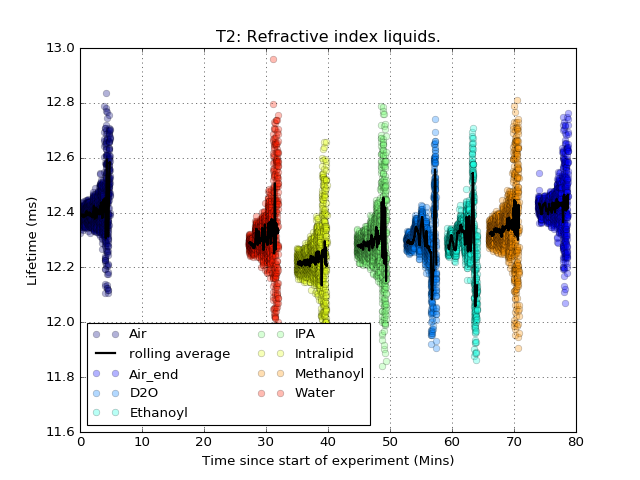

In [6]:
# Create colormap for plotting
n = len(df.medium.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# All in one
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
#     ax.plot(group['delta'], rolling, '-', lw=2, label='rolling ({k})'.format(k=key), color='black')
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
plt.title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
if save:
    plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime.png', dpi=500)

# Add refractive index value to each medium

In [7]:
# Ethanol and methanolspelt wrong...

n = {'Air': 1,
     'Water': 1.32,
     'Intralipid': 1.35,
     'IPA': 1.3741,
     'D2O': 1.32,
     'Ethanoyl': 1.3509,
     'Methanoyl': 1.3176,
     'Air_end': 1}
n

{'Air': 1,
 'Air_end': 1,
 'D2O': 1.32,
 'Ethanoyl': 1.3509,
 'IPA': 1.3741,
 'Intralipid': 1.35,
 'Methanoyl': 1.3176,
 'Water': 1.32}

In [8]:
df['n'] = df['medium']
df = df.replace({"n": n})

In [22]:
grouped = df.groupby(['n'])

## tau & A vs concentration

In [14]:
g = df2.groupby(['n', 'medium']).agg([np.mean, np.std])
df2 = df[['n', 'current', 'tau', 'A', 'medium']]
g.head(10)

current                  tau                   A          
                     mean       std       mean       std      mean       std
n      medium                                                               
1.0000 Air            0.3  0.141478  12.410419  0.083947  0.260039  0.145961
       Air_end        0.3  0.141478  12.423925  0.075054  0.314796  0.176902
1.3176 Methanoyl      0.3  0.141478  12.347149  0.105516  0.236011  0.132329
1.3200 D2O            0.3  0.141478  12.301188  0.096058  0.241117  0.135250
       Water          0.3  0.141478  12.316506  0.114856  0.231808  0.130195
1.3500 Intralipid     0.3  0.141478  12.225940  0.100060  0.232586  0.130573
1.3509 Ethanoyl       0.3  0.141478  12.298883  0.105631  0.233993  0.131221
1.3741 IPA            0.3  0.141478  12.298051  0.106593  0.234169  0.131763

In [25]:
df2 = df[['n', 'current', 'tau', 'A', 'medium']]
# Apply mean and std functions to all collumns
g = df2.groupby(['current', 'n']).agg([np.mean, np.std])
g.head()

tau                   A          
                     mean       std      mean       std
current n                                              
0.1     1.0000  12.449398  0.157562  0.058265  0.005649
        1.3176  12.379380  0.212958  0.048012  0.000691
        1.3200  12.316074  0.218758  0.048160  0.001305
        1.3500  12.231972  0.204175  0.047249  0.000661
        1.3509  12.253157  0.212097  0.047865  0.000718

In [26]:
g2 = g.reset_index()
g3 = g2.groupby('current')

<IPython.core.display.Javascript object>


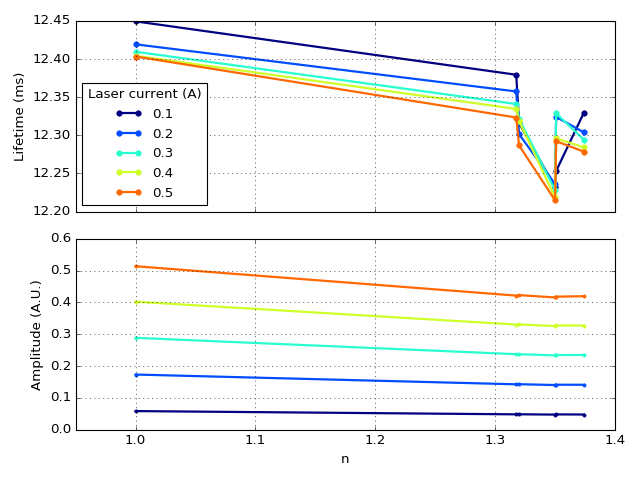

In [27]:
# Create colormap for plotting
num = len(df.current.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/num) for i in range(num)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for key, group in g3:
    ax1.plot(group['n'], group['tau']['mean'], '.-', lw='2', markersize='10', label=key)
    ax2.plot(group['n'], group['A']['mean'], '.-', lw='2', label=key)

ax2.set_xlabel('n')
ax1.set_ylabel('Lifetime (ms)')
ax2.set_ylabel('Amplitude (A.U.)')

ax1.grid()
ax2.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')
# ax1.set_title('{}: Refractive index liquids.'.format(df.chip.unique()[0]))
ax1.legend(title='Laser current (A)', loc='best', fontsize='medium')
# if save:
#     plt.savefig(data_folder +  str(folder) + '/final.png', dpi=500)

In [114]:
g2.head()

current       n      fs       humidity           optical power            \
                     mean  std      mean       std          mean       std   
0     0.1  1.0000  0.0001  0.0  36.10468  0.952769      0.030030  0.000153   
1     0.1  1.3176  0.0001  0.0  35.02472  0.026269      0.029970  0.000116   
2     0.1  1.3200  0.0001  0.0  35.06060  0.158620      0.029964  0.000135   
3     0.1  1.3500  0.0001  0.0  34.68788  0.025331      0.030010  0.000171   
4     0.1  1.3509  0.0001  0.0  34.67776  0.041486      0.029971  0.000106   

  sample_no         ...         tempC                   A            \
       mean  std    ...          mean       std      mean       std   
0      1000  0.0    ...      23.38056  0.160500  0.058265  0.005649   
1      1000  0.0    ...      23.53192  0.014011  0.048012  0.000691   
2      1000  0.0    ...      23.46160  0.078172  0.048160  0.001305   
3      1000  0.0    ...      23.43420  0.008571  0.047249  0.000661   
4      1000  0.0    ...      23.54348  0.009542  0.047865  0.000718   

         tau                   c                delta             
        mean       std      mean       std       mean        std  
0  12.449398  0.157562 -0.021875  0.000385  41.309124  36.979652  
1  12.379380  0.212958 -0.022446  0.000089  70.321634   0.259061  
2  12.316074  0.218758 -0.021968  0.000176  44.270795  12.759816  
3  12.231972  0.204175 -0.021892  0.000169  39.329071   0.257544  
4  12.253157  0.212097 -0.022264  0.000249  63.607962   0.258923  

[5 rows x 28 columns]

In [28]:
x = g2.n
y = g2.current

<IPython.core.display.Javascript object>


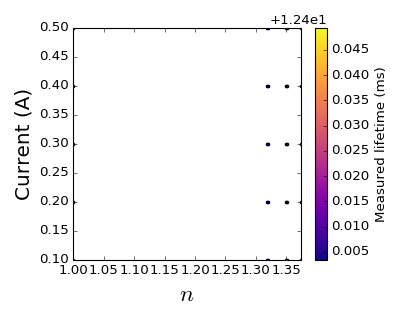

In [29]:
z = g2['tau']['mean']
fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(111)
xi = np.linspace(min(x), max(y), len(x))
yi = np.linspace(min(y), max(y), len(y))
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

plt.contour(xi, yi, zi, 15, linewidths=1, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
cbar = plt.colorbar()
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)

plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar.ax.set_ylabel('Measured lifetime (ms)', fontsize=12)
ax.set_xlabel('$n$', fontsize=21)
ax.set_ylabel('Current (A)', fontsize=18)
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/contour_tau.pdf', dpi=300)

In [15]:
# Equation for 980 nm laser drive current to power (measured)
def f(x): return 33*x - 1.5

Assume light leaving collimator has a gaussian profile. Hole through which the light goes cuts the beam off at 1/e^2 diameter. Therefore fraction of area under the gaussian curve is

In [16]:
# Convert current to laser power in W/cm^2
y = [f(d) for d in y]

<IPython.core.display.Javascript object>


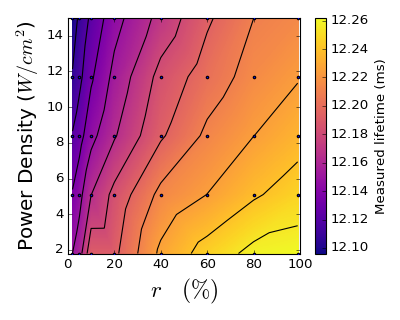

In [19]:
z = g2['tau']['mean']
fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(111)
xi = np.linspace(0, 100, 500)
yi = np.linspace(min(y), max(y), 500)
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

plt.contour(xi, yi, zi, 15, linewidths=1, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
cbar = plt.colorbar()
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)

plt.xlim(0, 100)
plt.ylim(min(y), max(y))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar.ax.set_ylabel('Measured lifetime (ms)', fontsize=12)
ax.set_xlabel(r'$ r \quad (\%)$', fontsize=21)
ax.set_ylabel(r'Power Density ($ W / cm^2$)', fontsize=18)
plt.tight_layout()
if save:
    plt.savefig(data_folder +  str(folder) + '/contour_tau.pdf', dpi=300)
    pass